In [1]:
%run ../../../shared_setup.ipynb

The Cython magic has been move to the Cython package, hence 
`%load_ext cythonmagic` is deprecated; Please use `%load_ext Cython` instead.

Though, because I am nice, I'll still try to load it for you this time.


In [2]:
truth_dir = '/data/plasmodium/pfalciparum/pf-crosses/data/evaluation/truth'

In [28]:
evaluation_genes_hb3 = [
    'PF3D7_0106300',
    'PF3D7_0207300',
    'PF3D7_0207400',
    'PF3D7_0207500',
    'PF3D7_0207600',
    'PF3D7_0207700',
    'PF3D7_0207800',
    'PF3D7_0208000',
#     'PF3D7_0220800',  # exons only, need to manually edit bwamem alignment to handle introns properly
    'PF3D7_0304600',
    'PF3D7_0402300',  # expect some discordance between genbank and birren
    'PF3D7_0417200',  # looks like birren has a few errors
    'PF3D7_0424200', 
    'PF3D7_0508000',
    'PF3D7_0620400', 
    'PF3D7_0708400',
    'PF3D7_0709100',  # nice, has dense cluster of SNPs with good concordance
    'PF3D7_0709300', 
    'PF3D7_0804800',  # genbank has errors?
    'PF3D7_0831600',  # exons only, nice as has dense cluster of SNPs with good concordance
    'PF3D7_0902800', 
    'PF3D7_0905400',  # exons only
    'PF3D7_0929400',  # exons only
    'PF3D7_0935800',  # exons only
    'PF3D7_1115700',  # nice, dense SNP clusters
    'PF3D7_1133400',  # nice, lots of SNPs
    'PF3D7_1246100', 
    'PF3D7_1323500', 
    'PF3D7_1335000', 
    'PF3D7_1335100',  # almost no agreement between genbank and birren, genbank looks wrong
    'PF3D7_1337200', 
    'PF3D7_1434200', 
    'PF3D7_1447900', 
]
len(evaluation_genes_hb3)

32

In [29]:
lkp_feature[evaluation_genes[0]]

('Pf3D7_01_v3',
 'gene',
 265208,
 269173,
 3965,
 '-',
 'PF3D7_0106300',
 None,
 'ATP6',
 'PFA0310c',
 'Core',
 365031)

In [8]:
fasta_fn = '/data/plasmodium/pfalciparum/pf-crosses/data/genome/sanger/version3/September_2012/Pf3D7_v3.lookseq.fa'

In [9]:
genome = pyfasta.Fasta(fasta_fn)

In [23]:
def call_variants(bam_fn, gene_ids):
    bam = pysam.AlignmentFile(bam_fn)
    tbl = [['CHROM', 'POS', 'REF', 'ALT', 'svtype', 'svlen', 'gene']]
    for gene_id in gene_ids:
        gene = lkp_feature[gene_id]
        chrom = gene.feature_chrom
        seq = genome[chrom]
        for col in bam.pileup(reference=chrom, start=gene.feature_start, end=gene.feature_stop, 
                              stepper='nofilter', truncate=True):
            ref_base = seq[col.reference_pos]
            for read in col.pileups:
                row = None
                if read.indel < 0:
                    ref_allele = seq[col.reference_pos:col.reference_pos + -1*read.indel + 1]
                    alt_allele = ref_base
                    row = [chrom, col.reference_pos + 1, ref_allele, alt_allele, 'DEL', len(alt_allele) - len(ref_allele), gene_id]
                elif read.indel > 0:
                    ref_allele = ref_base
                    alt_allele = read.alignment.query_sequence[read.query_position:read.query_position + read.indel + 1]
                    row = [chrom, col.reference_pos + 1, ref_allele, alt_allele, 'INS', len(alt_allele) - len(ref_allele), gene_id]
                elif not read.is_del and ref_base != read.alignment.query_sequence[read.query_position]:
                    ref_allele = ref_base
                    alt_allele = read.alignment.query_sequence[read.query_position]
                    row = [chrom, col.reference_pos + 1, ref_allele, alt_allele, 'SNP', 0, gene_id]
                if row:
                    tbl.append(row)
    return etl.wrap(tbl)
        

In [93]:
def trim_alleles(a, b):

    # SNPs or already trimmed
    if len(a) == 1 or len(b) == 1:
        return a, b
    
    # check reference base
    ref_base = a[0]
    if a[0] != b[0]:
        # REF bases don't match, complex variant
        return a, b

    # sort by length, shortest first
    reverse = False
    if len(a) > len(b):
        a, b = b, a
        reverse = True
    
    # pick off suffix
    a_suffix = a[1:]
    b_suffix = b[1:]
    
    # trim
    if b_suffix.endswith(a_suffix):
        a = ref_base
        b = ref_base + b_suffix[:-1*len(a_suffix)]
        
    if reverse:
        return b, a
    else:
        return a, b 

In [97]:
gatk_callset_fn_template = '/data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/{cross}.gatk.final.npz'

def tabulate_variants_gatk(cross, parent):

    callset_gatk = np.load(gatk_callset_fn_template.format(cross=cross))
    variants = callset_gatk['variants']

    # select variants
    filter_condition = numexpr.evaluate('~FILTER_CNV & '
                                        '~FILTER_DUP_SITE & '
                                        '~FILTER_LOW_CONFIDENCE & '
                                        '~FILTER_LOW_CONFIDENCE_PARENT & '
                                        '~FILTER_MISSING_PARENT & '
                                        '~FILTER_NON_CORE & '
                                        '~FILTER_NON_MENDELIAN',
                                        local_dict=variants)
    log(callset_gatk['calldata'].dtype.names[parent])
    c2d = vcfnp.view2d(callset_gatk['calldata'])
    genotype = c2d['genotype']
    genotype_parent = genotype[:, parent]
    genotype_condition = genotype_parent > 0
    condition = filter_condition & genotype_condition
    log('n_variants', nnz(condition))

    # apply selection
    variants = np.compress(condition, variants)
    genotype_parent = np.compress(condition, genotype_parent)

    # construct table
    tbl = (etl
        .fromarray(variants)
        .addcolumn('genotype', genotype_parent)
        .cut('CHROM', 'POS', 'REF', 'ALT', 'genotype')
        .convert('ALT', lambda v, row: v[row.genotype-1], pass_row=True)
        .cutout('genotype')
        .convert(['CHROM', 'REF', 'ALT'], lambda v: str(v, 'ascii')) 
        .addfield('trim', lambda row: trim_alleles(row.REF, row.ALT))
        .unpack('trim', ['REF_trim', 'ALT_trim'])
        .cutout('REF', 'ALT')
        .rename({'REF_trim': 'REF', 'ALT_trim': 'ALT'})
        .addfield('svlen', lambda row: len(row.ALT) - len(row.REF))
        .addfield('svtype', lambda row: 'SNP' if row.svlen == 0 else 'INS' if row.svlen > 0 else 'DEL')
        .intervaljoinvalues(tbl_genes, value='feature_id', lkey='CHROM', lstart='POS', lstop='POS', 
                            rkey='feature_chrom', rstart='feature_start', rstop='feature_stop', include_stop=True)
        .rename('feature_id', 'gene')
        .convert('gene', lambda v: v[0] if v else None)
    )
    
    return tbl
    

In [98]:
cortex_callset_fn_template = '/data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/{cross}.cortex.final.npz'

def tabulate_variants_cortex(cross, parent):

    callset_cortex = np.load(cortex_callset_fn_template.format(cross=cross))
    variants = callset_cortex['variants']

    # select variants
    filter_condition = numexpr.evaluate('~FILTER_CNV & '
                                        '~FILTER_DUP_ALLELE & '
                                        '~FILTER_DUP_SITE & '
                                        '~FILTER_LOW_CONFIDENCE & '
                                        '~FILTER_LOW_CONFIDENCE_PARENT & '
                                        '~FILTER_MAPQ & '
                                        '~FILTER_MISMAPPED_UNPLACEABLE & '
                                        '~FILTER_MISSING_PARENT & '
                                        '~FILTER_MULTIALLELIC & '
                                        '~FILTER_NON_CORE & '
                                        '~FILTER_NON_MENDELIAN & '
                                        '~FILTER_OVERLAPPING_SITE & '
                                        '~FILTER_PF_FAIL_ERROR & '
                                        '~FILTER_PF_FAIL_REPEAT',
                                        local_dict=variants)
    log(callset_cortex['calldata'].dtype.names[parent])
    c2d = vcfnp.view2d(callset_cortex['calldata'])
    genotype = c2d['genotype']
    genotype_parent = genotype[:, parent]
    genotype_condition = genotype_parent > 0
    condition = filter_condition & genotype_condition
    log('n_variants', nnz(condition))

    # apply selection
    variants = np.compress(condition, variants)
    genotype_parent = np.compress(condition, genotype_parent)

    # construct table
    tbl = (etl
        .fromarray(variants)
        .addcolumn('genotype', genotype_parent)
        .cut('CHROM', 'POS', 'REF', 'ALT', 'genotype')
        .convert('ALT', lambda v, row: v[row.genotype-1], pass_row=True)
        .cutout('genotype')
        .convert(['CHROM', 'REF', 'ALT'], lambda v: str(v, 'ascii')) 
        .addfield('trim', lambda row: trim_alleles(row.REF, row.ALT))
        .unpack('trim', ['REF_trim', 'ALT_trim'])
        .cutout('REF', 'ALT')
        .rename({'REF_trim': 'REF', 'ALT_trim': 'ALT'})
        .addfield('svlen', lambda row: len(row.ALT) - len(row.REF))
        .addfield('svtype', lambda row: 'SNP' if row.svlen == 0 else 'INS' if row.svlen > 0 else 'DEL')
        .intervaljoinvalues(tbl_genes, value='feature_id', lkey='CHROM', lstart='POS', lstop='POS', 
                            rkey='feature_chrom', rstart='feature_start', rstop='feature_stop', include_stop=True)
        .rename('feature_id', 'gene')
        .convert('gene', lambda v: v[0] if v else None)
    )
    
    return tbl
    

In [127]:
def confusion_3way(tables, labels, key):
    # assume t1 is the discovery set, t2 and t3 are truth sets
    t1, t2, t3 = tables
    
    # set up confusion table
    tbl_confusion = [['variant_type', 'TP', 'FP', 'FN', 'FDR', 'sensitivity']]
    
    # all variants
    s1 = t1.values(*key).set()
    s2 = t2.values(*key).set()
    s3 = t3.values(*key).set()
    fp = len(s1 - (s2 | s3))  # only in discovery set
    fn = len((s2 & s3) - s1)  # in both truth sets, not in discovery
    tp = len(s1 & (s2 | s3))  # in discovery and at least one truth set
    fdr = fp / (fp + tp)
    sensitivity = tp / (tp + fn)
    tbl_confusion.append(['all variants', tp, fp, fn, fdr, sensitivity])

    fig = plt.figure(figsize=(3, 6))
    
    # SNPs
    s1 = t1.eq('svtype', 'SNP').values(*key).set()
    s2 = t2.eq('svtype', 'SNP').values(*key).set()
    s3 = t3.eq('svtype', 'SNP').values(*key).set()
    ax = fig.add_subplot(211)
    ax.set_title('SNPs', fontsize=14, fontweight='bold')
    venn.venn3([s1, s2, s3], set_labels=labels)
    fp = len(s1 - (s2 | s3))  # only in discovery set
    fn = len((s2 & s3) - s1)  # in both truth sets, not in discovery
    tp = len(s1 & (s2 | s3))  # in discovery and at least one truth set
    fdr = fp / (fp + tp)
    sensitivity = tp / (tp + fn)
    tbl_confusion.append(['SNPs', tp, fp, fn, fdr, sensitivity])
    
    # INDELs
    s1 = t1.selectin('svtype', {'INS', 'DEL'}).values(*key).set()
    s2 = t2.selectin('svtype', {'INS', 'DEL'}).values(*key).set()
    s3 = t3.selectin('svtype', {'INS', 'DEL'}).values(*key).set()
    ax = fig.add_subplot(212)
    ax.set_title('INDELs', fontsize=14, fontweight='bold')
    venn.venn3([s1, s2, s3], set_labels=labels)
    fp = len(s1 - (s2 | s3))  # only in discovery set
    fn = len((s2 & s3) - s1)  # in both truth sets, not in discovery
    tp = len(s1 & (s2 | s3))  # in discovery and at least one truth set
    fdr = fp / (fp + tp)
    sensitivity = tp / (tp + fn)
    tbl_confusion.append(['INDELs', tp, fp, fn, fdr, sensitivity])
    
    (etl.wrap(tbl_confusion)
     .convert(('FDR', 'sensitivity'), lambda v: '{:.1f}%'.format(v*100))
     .displayall(caption='confusion %s' % repr(key), index_header=False))
    

## HB3

In [55]:
bam_fn_hb3_birren = os.path.join(truth_dir, 'bwamem_intractg', 'alignment', 'birren_hb3_contigs.bam')
tbl_variants_hb3_birren = call_variants(bam_fn_hb3_birren, evaluation_genes_hb3)
tbl_variants_hb3_birren.display(caption='HB3 Birren contigs')

0|CHROM,1|POS,2|REF,3|ALT,4|svtype,5|svlen,6|gene
Pf3D7_01_v3,265603,CAT,C,DEL,-2,PF3D7_0106300
Pf3D7_01_v3,266073,A,ATT,INS,2,PF3D7_0106300
Pf3D7_01_v3,266480,A,T,SNP,0,PF3D7_0106300
Pf3D7_01_v3,266640,TCTC,T,DEL,-3,PF3D7_0106300
Pf3D7_01_v3,267777,C,T,SNP,0,PF3D7_0106300


In [56]:
bam_fn_hb3_genbank = os.path.join(truth_dir, 'bwamem_intractg', 'alignment', 'genbank_hb3_coding_sequences.bam')
tbl_variants_hb3_genbank = call_variants(bam_fn_hb3_genbank, evaluation_genes_hb3)
tbl_variants_hb3_genbank.display(caption='HB3 GenBank coding sequences')

0|CHROM,1|POS,2|REF,3|ALT,4|svtype,5|svlen,6|gene
Pf3D7_01_v3,265603,CAT,C,DEL,-2,PF3D7_0106300
Pf3D7_01_v3,266073,A,ATT,INS,2,PF3D7_0106300
Pf3D7_01_v3,266480,A,T,SNP,0,PF3D7_0106300
Pf3D7_01_v3,266640,TCTC,T,DEL,-3,PF3D7_0106300
Pf3D7_01_v3,267777,C,T,SNP,0,PF3D7_0106300


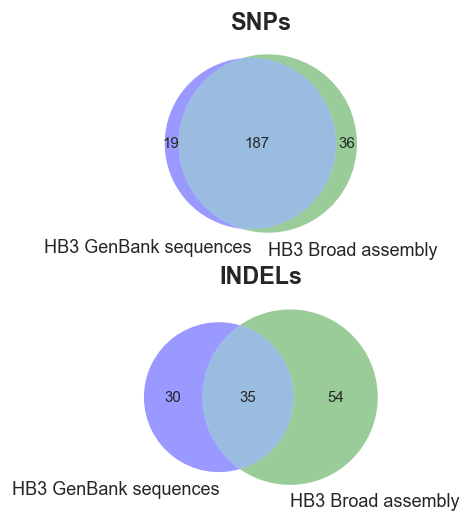

In [126]:
fig = plt.figure(figsize=(3, 5))

# SNPs
s1 = tbl_variants_hb3_genbank.eq('svtype', 'SNP').values('CHROM', 'POS', 'REF', 'ALT').set()
s2 = tbl_variants_hb3_birren.eq('svtype', 'SNP').values('CHROM', 'POS', 'REF', 'ALT').set()
ax = fig.add_subplot(2, 1, 1)
venn.venn2([s1, s2], set_labels=['HB3 GenBank sequences', 'HB3 Broad assembly'], 
           set_colors=['b', 'g'], ax=ax)
ax.set_title('SNPs', fontsize=14, fontweight='bold')

# INDELs
s1 = tbl_variants_hb3_genbank.selectin('svtype', {'INS', 'DEL'}).values('CHROM', 'POS', 'REF', 'ALT').set()
s2 = tbl_variants_hb3_birren.selectin('svtype', {'INS', 'DEL'}).values('CHROM', 'POS', 'REF', 'ALT').set()
ax = fig.add_subplot(2, 1, 2)
venn.venn2([s1, s2], set_labels=['HB3 GenBank sequences', 'HB3 Broad assembly'], 
           set_colors=['b', 'g'], ax=ax)
ax.set_title('INDELs', fontsize=14, fontweight='bold');

### HB3(1) GATK

In [71]:
tbl_variants_hb31_gatk = tabulate_variants_gatk('3d7_hb3', 1).selectin('gene', evaluation_genes_hb3).cache(10000)
tbl_variants_hb31_gatk.display(caption='HB3(1) GATK')

2015-04-14 21:53:41.115906 :: HB3/PG0052-C/ERR019054
2015-04-14 21:53:41.592273 :: n_variants 36635


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|gene
Pf3D7_01_v3,265603,CAT,C,-2,DEL,PF3D7_0106300
Pf3D7_01_v3,266480,A,T,0,SNP,PF3D7_0106300
Pf3D7_01_v3,266640,TCTC,T,-3,DEL,PF3D7_0106300
Pf3D7_01_v3,267777,C,T,0,SNP,PF3D7_0106300
Pf3D7_01_v3,269132,C,T,0,SNP,PF3D7_0106300


variant_type,TP,FP,FN,FDR,sensitivity
all variants,220,11,51,4.8%,81.2%
SNPs,178,5,33,2.7%,84.4%
INDELs,42,6,18,12.5%,70.0%


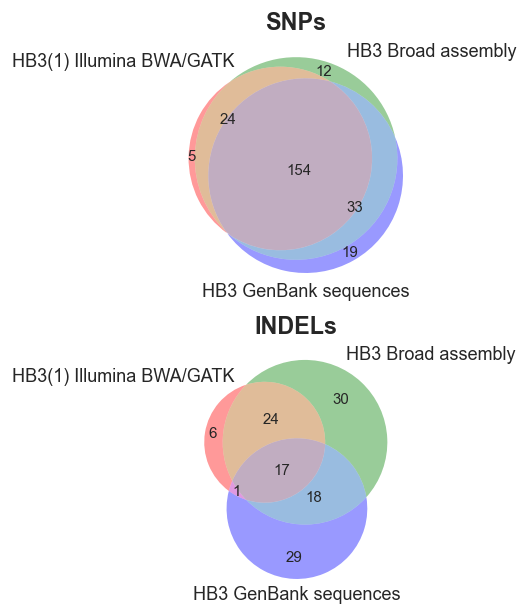

In [128]:
tables = tbl_variants_hb31_gatk, tbl_variants_hb3_birren, tbl_variants_hb3_genbank
labels = 'HB3(1) Illumina BWA/GATK', 'HB3 Broad assembly', 'HB3 GenBank sequences'
confusion_3way(tables, labels, key=('CHROM', 'POS', 'REF', 'ALT'))

variant_type,TP,FP,FN,FDR,sensitivity
all variants,223,8,51,3.5%,81.4%
SNPs,178,5,33,2.7%,84.4%
INDELs,45,3,18,6.2%,71.4%


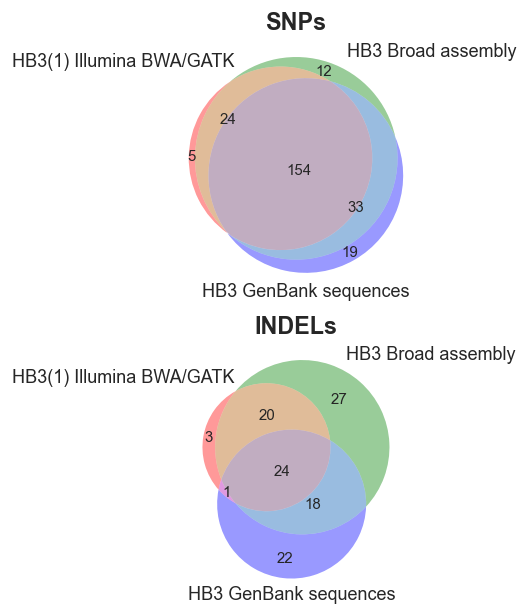

In [129]:
tables = tbl_variants_hb31_gatk, tbl_variants_hb3_birren, tbl_variants_hb3_genbank
labels = 'HB3(1) Illumina BWA/GATK', 'HB3 Broad assembly', 'HB3 GenBank sequences'
confusion_3way(tables, labels, key=('CHROM', 'POS', 'svtype'))

### HB3(2) GATK

In [86]:
tbl_variants_hb32_gatk = tabulate_variants_gatk('hb3_dd2', 0).selectin('gene', evaluation_genes_hb3).cache(10000)
tbl_variants_hb32_gatk.display(caption='HB3(2) GATK')

2015-04-14 22:02:49.817643 :: HB3/PG0004-CW/ERR012788
2015-04-14 22:02:51.459409 :: n_variants 27786


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|gene
Pf3D7_01_v3,265603,CAT,C,-2,DEL,PF3D7_0106300
Pf3D7_01_v3,266480,A,T,0,SNP,PF3D7_0106300
Pf3D7_01_v3,266640,TCTC,T,-3,DEL,PF3D7_0106300
Pf3D7_01_v3,267777,C,T,0,SNP,PF3D7_0106300
Pf3D7_01_v3,269132,C,T,0,SNP,PF3D7_0106300


variant_type,TP,FP,FN,FDR,sensitivity
all variants,205,5,58,2.4%,77.9%
SNPs,171,1,39,0.6%,81.4%
INDELs,34,4,19,10.5%,64.2%


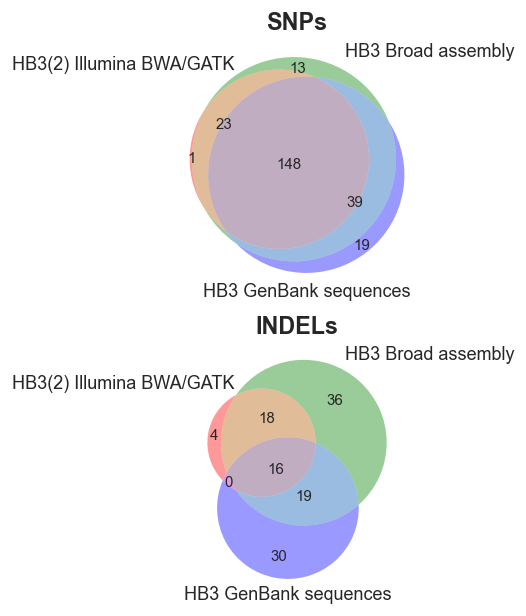

In [130]:
tables = tbl_variants_hb32_gatk, tbl_variants_hb3_birren, tbl_variants_hb3_genbank
labels = 'HB3(2) Illumina BWA/GATK', 'HB3 Broad assembly', 'HB3 GenBank sequences'
confusion_3way(tables, labels, key=('CHROM', 'POS', 'REF', 'ALT'))

variant_type,TP,FP,FN,FDR,sensitivity
all variants,207,3,60,1.4%,77.5%
SNPs,171,1,39,0.6%,81.4%
INDELs,36,2,21,5.3%,63.2%


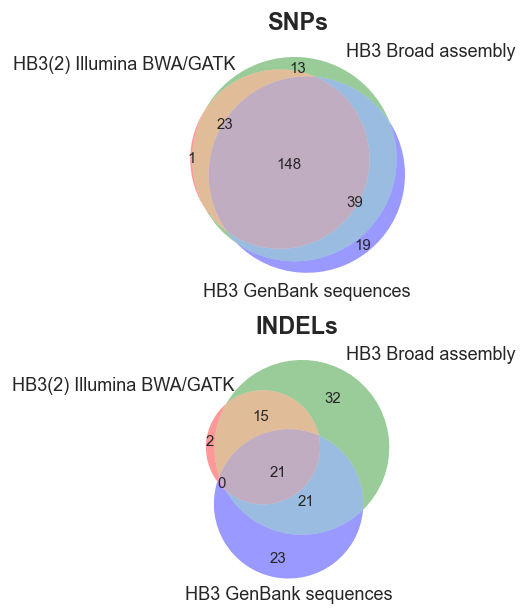

In [131]:
tables = tbl_variants_hb32_gatk, tbl_variants_hb3_birren, tbl_variants_hb3_genbank
labels = 'HB3(2) Illumina BWA/GATK', 'HB3 Broad assembly', 'HB3 GenBank sequences'
confusion_3way(tables, labels, key=('CHROM', 'POS', 'svtype'))

### HB3(1) Cortex 

In [99]:
tbl_variants_hb31_cortex = tabulate_variants_cortex('3d7_hb3', 1).selectin('gene', evaluation_genes_hb3).cache(10000)
tbl_variants_hb31_cortex.display(caption='HB3(1) Cortex')

2015-04-14 22:15:09.338662 :: HB3/PG0052-C/ERR019054
2015-04-14 22:15:09.451758 :: n_variants 27278


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|gene
Pf3D7_01_v3,265603,CAT,C,-2,DEL,PF3D7_0106300
Pf3D7_01_v3,266480,A,T,0,SNP,PF3D7_0106300
Pf3D7_01_v3,267777,C,T,0,SNP,PF3D7_0106300
Pf3D7_01_v3,269132,C,T,0,SNP,PF3D7_0106300
Pf3D7_02_v3,290368,G,GATAT,4,INS,PF3D7_0207300


variant_type,TP,FP,FN,FDR,sensitivity
all variants,226,6,34,2.6%,86.9%
SNPs,188,2,22,1.1%,89.5%
INDELs,38,4,12,9.5%,76.0%


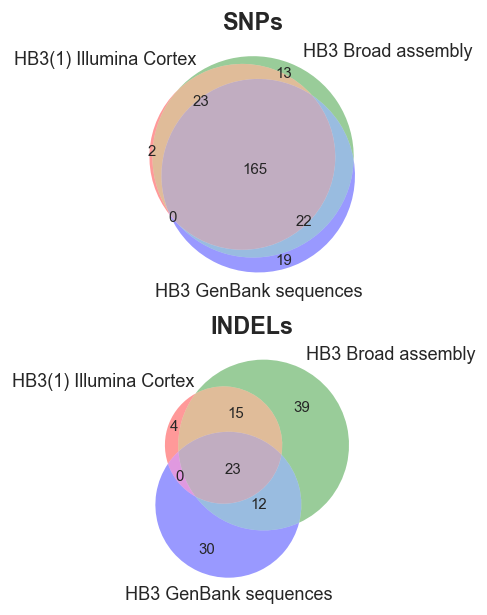

In [132]:
tables = tbl_variants_hb31_cortex, tbl_variants_hb3_birren, tbl_variants_hb3_genbank
labels = 'HB3(1) Illumina Cortex', 'HB3 Broad assembly', 'HB3 GenBank sequences'
confusion_3way(tables, labels, key=('CHROM', 'POS', 'REF', 'ALT'))

variant_type,TP,FP,FN,FDR,sensitivity
all variants,226,6,37,2.6%,85.9%
SNPs,188,2,22,1.1%,89.5%
INDELs,38,4,15,9.5%,71.7%


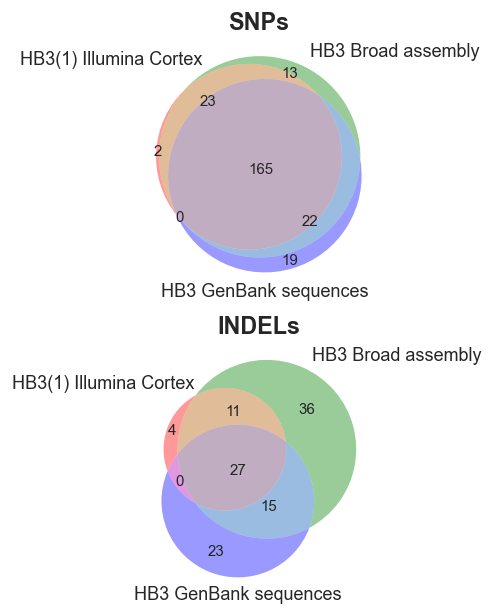

In [133]:
tables = tbl_variants_hb31_cortex, tbl_variants_hb3_birren, tbl_variants_hb3_genbank
labels = 'HB3(1) Illumina Cortex', 'HB3 Broad assembly', 'HB3 GenBank sequences'
confusion_3way(tables, labels, key=('CHROM', 'POS', 'svtype'))

### HB3(2) Cortex

In [102]:
tbl_variants_hb32_cortex = tabulate_variants_cortex('hb3_dd2', 0).selectin('gene', evaluation_genes_hb3).cache(10000)
tbl_variants_hb32_cortex.display(caption='HB3(2) Cortex')

2015-04-14 22:18:38.934412 :: HB3/PG0004-CW/ERR012788
2015-04-14 22:18:39.335819 :: n_variants 13192


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|gene
Pf3D7_01_v3,265603,CAT,C,-2,DEL,PF3D7_0106300
Pf3D7_01_v3,266640,TCTC,T,-3,DEL,PF3D7_0106300
Pf3D7_01_v3,267777,C,T,0,SNP,PF3D7_0106300
Pf3D7_01_v3,269132,C,T,0,SNP,PF3D7_0106300
Pf3D7_02_v3,290667,G,C,0,SNP,PF3D7_0207300


variant_type,TP,FP,FN,FDR,sensitivity
all variants,68,1,166,1.4%,29.1%
SNPs,57,0,137,0.0%,29.4%
INDELs,11,1,29,8.3%,27.5%


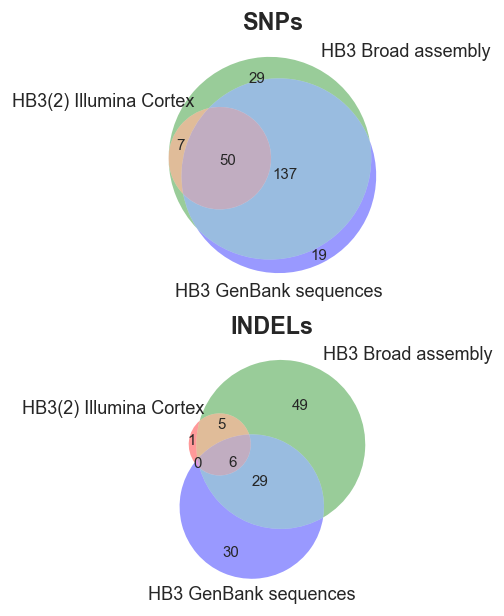

In [134]:
tables = tbl_variants_hb32_cortex, tbl_variants_hb3_birren, tbl_variants_hb3_genbank
labels = 'HB3(2) Illumina Cortex', 'HB3 Broad assembly', 'HB3 GenBank sequences'
confusion_3way(tables, labels, key=('CHROM', 'POS', 'REF', 'ALT'))

variant_type,TP,FP,FN,FDR,sensitivity
all variants,68,1,172,1.4%,28.3%
SNPs,57,0,137,0.0%,29.4%
INDELs,11,1,35,8.3%,23.9%


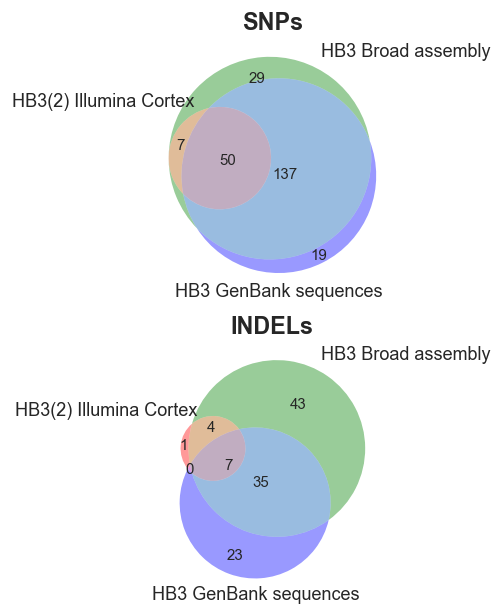

In [135]:
tables = tbl_variants_hb32_cortex, tbl_variants_hb3_birren, tbl_variants_hb3_genbank
labels = 'HB3(2) Illumina Cortex', 'HB3 Broad assembly', 'HB3 GenBank sequences'
confusion_3way(tables, labels, key=('CHROM', 'POS', 'svtype'))

### HB3(1) combined

variant_type,TP,FP,FN,FDR,sensitivity
all variants,245,17,28,6.5%,89.7%
SNPs,192,7,20,3.5%,90.6%
INDELs,53,10,8,15.9%,86.9%


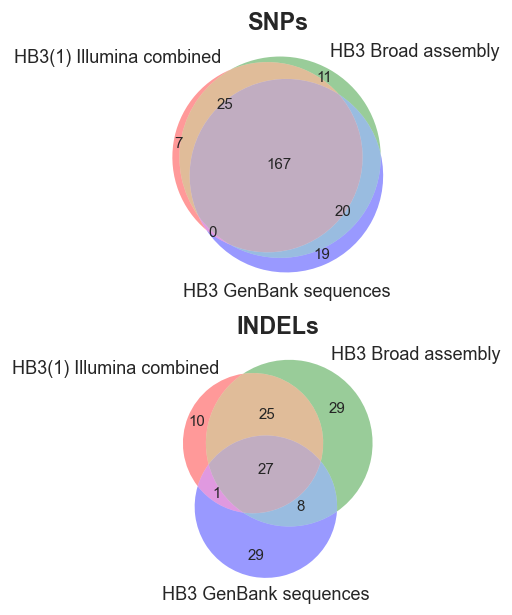

In [136]:
tbl_variants_hb31_combined = tbl_variants_hb31_gatk.cat(tbl_variants_hb31_cortex)
tables = tbl_variants_hb31_combined, tbl_variants_hb3_birren, tbl_variants_hb3_genbank
labels = 'HB3(1) Illumina combined', 'HB3 Broad assembly', 'HB3 GenBank sequences'
confusion_3way(tables, labels, key=('CHROM', 'POS', 'REF', 'ALT'))

### HB3(2) combined

variant_type,TP,FP,FN,FDR,sensitivity
all variants,210,6,54,2.8%,79.5%
SNPs,173,1,37,0.6%,82.4%
INDELs,37,5,17,11.9%,68.5%


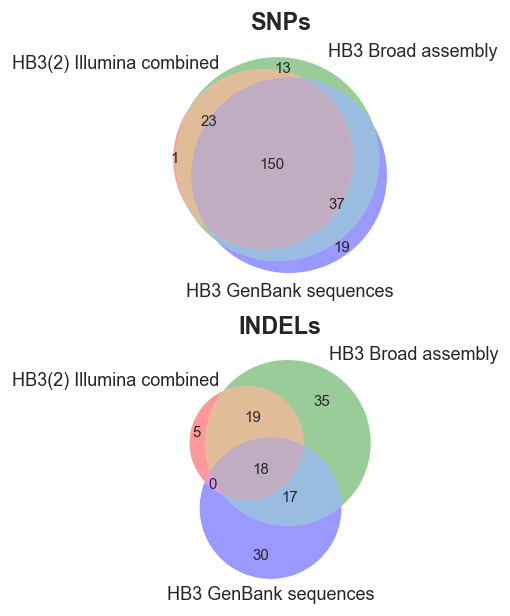

In [137]:
tbl_variants_hb32_combined = tbl_variants_hb32_gatk.cat(tbl_variants_hb32_cortex)
tables = tbl_variants_hb32_combined, tbl_variants_hb3_birren, tbl_variants_hb3_genbank
labels = 'HB3(2) Illumina combined', 'HB3 Broad assembly', 'HB3 GenBank sequences'
confusion_3way(tables, labels, key=('CHROM', 'POS', 'REF', 'ALT'))

## Sandbox

In [30]:
alignment_method = 'bwamem_intractg'
assembly = 'genbank_hb3_coding_sequences'
bam_fn = os.path.join(truth_dir, alignment_method, 'alignment', assembly + '.bam')
!ls -lh {bam_fn}
tbl_variants = call_variants(bam_fn, evaluation_genes_hb3[:2])
tbl_variants.displayall()

-rw-rw-r-- 1 aliman aliman 52K Apr 14 08:44 /data/plasmodium/pfalciparum/pf-crosses/data/evaluation/truth/bwamem_intractg/alignment/genbank_hb3_coding_sequences.bam


0|CHROM,1|POS,2|REF,3|ALT,4|svtype,5|svlen,6|gene
Pf3D7_01_v3,265603,CAT,C,DEL,-2,PF3D7_0106300
Pf3D7_01_v3,266073,A,ATT,INS,2,PF3D7_0106300
Pf3D7_01_v3,266480,A,T,SNP,0,PF3D7_0106300
Pf3D7_01_v3,266640,TCTC,T,DEL,-3,PF3D7_0106300
Pf3D7_01_v3,267777,C,T,SNP,0,PF3D7_0106300
Pf3D7_01_v3,269132,C,T,SNP,0,PF3D7_0106300
Pf3D7_02_v3,290368,G,GATAT,INS,4,PF3D7_0207300
Pf3D7_02_v3,290569,T,A,SNP,0,PF3D7_0207300
Pf3D7_02_v3,290572,T,A,SNP,0,PF3D7_0207300
Pf3D7_02_v3,290667,G,C,SNP,0,PF3D7_0207300


In [31]:
alignment_method = 'bwamem_intractg'
assembly = 'birren_hb3_contigs'
bam_fn = os.path.join(truth_dir, alignment_method, 'alignment', assembly + '.bam')
!ls -lh {bam_fn}
tbl_variants = call_variants(bam_fn, evaluation_genes_hb3[:2])
tbl_variants.displayall()

-rw-rw-r-- 1 aliman aliman 13M Apr 13 16:12 /data/plasmodium/pfalciparum/pf-crosses/data/evaluation/truth/bwamem_intractg/alignment/birren_hb3_contigs.bam


0|CHROM,1|POS,2|REF,3|ALT,4|svtype,5|svlen,6|gene
Pf3D7_01_v3,265603,CAT,C,DEL,-2,PF3D7_0106300
Pf3D7_01_v3,266073,A,ATT,INS,2,PF3D7_0106300
Pf3D7_01_v3,266480,A,T,SNP,0,PF3D7_0106300
Pf3D7_01_v3,266640,TCTC,T,DEL,-3,PF3D7_0106300
Pf3D7_01_v3,267777,C,T,SNP,0,PF3D7_0106300
Pf3D7_01_v3,269132,C,T,SNP,0,PF3D7_0106300
Pf3D7_02_v3,290368,G,GATAT,INS,4,PF3D7_0207300
Pf3D7_02_v3,290569,T,A,SNP,0,PF3D7_0207300
Pf3D7_02_v3,290572,T,A,SNP,0,PF3D7_0207300
Pf3D7_02_v3,290667,G,C,SNP,0,PF3D7_0207300
